In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import  SVC
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from skopt import BayesSearchCV
from skopt.space import Real,Integer, Categorical
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.pipeline import make_pipeline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)


In [203]:
training = pd.read_csv('train.csv')
train_data = training.copy()

In [204]:
test_data = pd.read_csv('test.csv')

In [205]:
# label encoding
lbl = LabelEncoder()
cat_feats = [f for f in train_data.columns if train_data[f].dtype == object]
for f in cat_feats:
    train_data[f] = lbl.fit_transform(train_data[f])
    test_data[f] = lbl.transform(test_data[f])

In [206]:
train_id = train_data.Id
train_data = train_data.drop(['Behaviour','Id'],axis = 1)

In [207]:
train_data['PerformanceRating'] = train_data['PerformanceRating'].apply(lambda x: 0 if x == 3 else 1)
test_data['PerformanceRating'] = test_data['PerformanceRating'].apply(lambda x: 0 if x == 3 else 1)

In [208]:
test_id = test_data.Id
test_data = test_data.drop(['Behaviour','Id'],axis = 1)

In [209]:
X = train_data.drop('Attrition',axis = 1)
y = train_data.Attrition

In [9]:
# Standard Scaling
skf = StratifiedKFold(n_splits = 10,random_state=42,shuffle=True)

numeric = ['Age','MonthlyIncome','EmployeeNumber']
scale_pipe = make_column_transformer((StandardScaler(),numeric))
pipe_rf = make_pipeline(scale_pipe,RandomForestClassifier())
pipe_xgb = make_pipeline(scale_pipe,XGBClassifier())

print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='accuracy')))
print('XGB: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_xgb,scoring='accuracy')))

RF:  0.9447208967658864
XGB:  0.9269143376505339


In [10]:
# target encoding  - 83%
numeric = ['Age','MonthlyIncome','EmployeeNumber']
categorical = [f for f in X.columns if f not in numeric]
pre_pipe = make_column_transformer((TargetEncoder(),categorical),(StandardScaler(),numeric))
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
pipe_xgb = make_pipeline(pre_pipe,XGBClassifier())

print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='accuracy')))
print('XGB: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_xgb,scoring='accuracy')))

RF:  0.9803453760508974
XGB:  0.9631523138680602


In [11]:
ohe_cols = []
for f in X.columns:
    if X[f].nunique()<10:
        print('Train')
        print(X[f].value_counts())
        print('Test')
        print(test_data[f].value_counts())
        ohe_cols.append(f)
        

Train
2    1105
1     403
0     120
Name: BusinessTravel, dtype: int64
Test
2    334
1     78
0     58
Name: BusinessTravel, dtype: int64
Train
1    979
2    568
0     81
Name: Department, dtype: int64
Test
1    314
2    138
0     18
Name: Department, dtype: int64
Train
3    644
4    434
2    306
1    201
5     43
Name: Education, dtype: int64
Test
3    180
4    124
2    100
1     49
5     17
Name: Education, dtype: int64
Train
1    623
3    521
2    197
5    162
4     85
0     40
Name: EducationField, dtype: int64
Test
1    203
3    131
2     54
5     50
4     25
0      7
Name: EducationField, dtype: int64
Train
3    480
4    472
1    372
2    304
Name: EnvironmentSatisfaction, dtype: int64
Test
3    149
4    138
1     92
2     91
Name: EnvironmentSatisfaction, dtype: int64
Train
1    996
0    632
Name: Gender, dtype: int64
Test
1    278
0    192
Name: Gender, dtype: int64
Train
3    925
2    447
4    130
1    126
Name: JobInvolvement, dtype: int64
Test
3    275
2    116
4     50
1   

In [12]:
# include OHE + target_encodeing
pre_pipe = make_column_transformer((TargetEncoder(),categorical),(StandardScaler(),numeric),(OneHotEncoder(),ohe_cols))

pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
pipe_xgb = make_pipeline(pre_pipe,XGBClassifier())

print('Validation Scores...')
print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='accuracy')))
print('XGB: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_xgb,scoring='accuracy')))

Validation Scores...
RF:  0.9809778080739227
XGB:  0.9637620237824736


In [13]:
# including more numeric features

numeric = [f for f in X.columns if X[f].nunique()>30]
pre_pipe = make_column_transformer((TargetEncoder(),categorical),(StandardScaler(),numeric),(OneHotEncoder(),ohe_cols))
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
pipe_xgb = make_pipeline(pre_pipe,XGBClassifier())

print('Validation Scores...')
print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='accuracy')))
print('XGB: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_xgb,scoring='accuracy')))

Validation Scores...
RF:  0.9766643944558053
XGB:  0.9637620237824736


In [81]:
# PCA - 20 - 98.2 highest, 23 - 98.4 highest, 25 - 98.2

pre_pipe = make_column_transformer((TargetEncoder(),categorical),(StandardScaler(),numeric))

pipe_rf = make_pipeline(pre_pipe,PCA(n_components=22),RandomForestClassifier())
pipe_xgb = make_pipeline(pre_pipe, PCA(n_components=22), XGBClassifier())
pipe_svc = make_pipeline(pre_pipe, PCA(n_components=22), SVC(probability=True))

print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='accuracy')))
print('XGB: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_xgb,scoring='accuracy')))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='accuracy')))

RF:  0.9889494811785202
XGB:  0.9735969097932289
SVC:  0.8900855866091041


In [ ]:
# tuning 

#pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
#params_grid = {
 #   'randomforestclassifier__n_estimators':[120,300,500,800,1200],
  #  'randomforestclassifier__max_depth':[5,8,15,25,20,None],
   # 'randomforestclassifier__min_samples_split':[1,2,5,10,15,100],
    #'randomforestclassifier__min_samples_leaf':[1,2,5,10],
    #'randomforestclassifier__max_features':['log2','sqrt',None]
#}


#rand_search = RandomizedSearchCV(estimator=pipe_rf,n_iter=200,n_jobs=-1,param_distributions=params_grid,cv = skf,verbose=5)
#rand_search.fit(X,y)
#print(rand_search.best_score_)
#print(rand_search.best_params_)

In [ ]:
# best estimator - tuning
#best_est = rand_search.best_estimator_
#print('Validation Scores...')
#print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=best_est,scoring='accuracy')))

In [ ]:
# tryin with Robust Scaler - less susceptible to outliers

numeric = ['Age','MonthlyIncome','EmployeeNumber']
pre_pipe = make_column_transformer((TargetEncoder(),categorical),(RobustScaler(),numeric),(OneHotEncoder(),ohe_cols))

pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
pipe_xgb = make_pipeline(pre_pipe,XGBClassifier())

print('Validation Scores...')
print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='accuracy')))
print('XGB: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_xgb,scoring='accuracy')))

In [ ]:
# feature selection - SelectFromModel
pre_pipe = make_column_transformer((TargetEncoder(),categorical),(RobustScaler(),numeric))
select_rf = SelectFromModel(estimator=RandomForestClassifier(),max_features=22,threshold=-np.inf)
pipe_rf_select = make_pipeline(pre_pipe,select_rf,RandomForestClassifier())

print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf_select,scoring='accuracy')))

In [ ]:
# feature selection - RFECV
rfecv = RFECV(estimator=RandomForestClassifier(),min_features_to_select=10,step=1,cv=skf)
pipe_rf_rfe = make_pipeline(pre_pipe,rfecv,RandomForestClassifier())

print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf_rfe,scoring='accuracy')))

In [ ]:
# feature importance - Random Forest
pre_pipe = make_column_transformer((TargetEncoder(),categorical),(RobustScaler(),numeric),remainder = 'passthrough')
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())

pipe_rf.fit(X,y)
X.iloc[:,pipe_rf.named_steps['randomforestclassifier'].feature_importances_.argsort()[::-1]]

In [ ]:
# feature selection - random forest
select_rf = SelectFromModel(estimator=RandomForestClassifier(),threshold=0.01)
pipe_rf_select = make_pipeline(pre_pipe,select_rf,RandomForestClassifier())
print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf_select,scoring='accuracy')))

In [ ]:
# including years with curr manager,years in current role, in numeric

numeric = ['Age','MonthlyIncome','EmployeeNumber','YearsWithCurrManager','YearsInCurrentRole']
categorical = [f for f in X.columns if f not in numeric]

pre_pipe = make_column_transformer((TargetEncoder(),categorical),(RobustScaler(),numeric))
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
pipe_xgb = make_pipeline(pre_pipe,XGBClassifier())

print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='accuracy')))
print('XGB: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_xgb,scoring='accuracy')))

In [79]:
# outlier detection using Isolation Forest - 83%

isf = IsolationForest(contamination=0.01,n_jobs=-1,n_estimators=100)
isf.fit(X)
pred = isf.predict(X)

X_out = X.copy()
X_out['outlier'] = pred
outliers = X_out[X_out.outlier==-1]

# drop outliers
X_new = X_out[X_out.outlier==1]
y_new = y[X_new.index]
X_new = X_new.drop('outlier',axis = 1)
pre_pipe = make_column_transformer((TargetEncoder(),categorical),(RobustScaler(),numeric))
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
pipe_xgb = make_pipeline(pre_pipe,XGBClassifier())

print('RF: ',np.mean(cross_val_score(X=X_new,y=y_new,cv=skf,estimator=pipe_rf,scoring='accuracy')))
print('XGB: ',np.mean(cross_val_score(X=X_new,y=y_new,cv=skf,estimator=pipe_xgb,scoring='accuracy')))

RF:  0.9820067479487771
XGB:  0.9633847097615215


In [76]:
#  xgb - 84%
categorical = ['BusinessTravel','EducationField','Department','Gender','JobRole','MaritalStatus','OverTime']
numeric = [f for f in X.columns if f not in categorical]

pre_pipe = make_column_transformer((TargetEncoder(),categorical),(RobustScaler(),numeric))
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
pipe_xgb = make_pipeline(pre_pipe,XGBClassifier())

print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='accuracy')))
print('XGB: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_xgb,scoring='accuracy')))

RF:  0.9803567371052033
XGB:  0.9656100886162233


In [144]:
# including SVC with STD scaler-OHE in object cols - 0.86603
categorical = [f for f in train_data.columns if train_data[f].dtype == object]
numeric = [f for f in X.columns if f not in categorical]
pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))

pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
pipe_xgb = make_pipeline(pre_pipe,XGBClassifier())
pipe_svc = make_pipeline(pre_pipe,SVC(probability=True))

print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='accuracy')))
print('XGB: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_xgb,scoring='accuracy')))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='accuracy')))

RF:  0.979743240172688
XGB:  0.9637658108005756
SVC:  0.9189540256002424


In [129]:
# trying PCA with rf
categorical = [f for f in train_data.columns if train_data[f].dtype == object]
numeric = [f for f in X.columns if f not in categorical]
pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))

pipe_rf = make_pipeline(pre_pipe,PCA(n_components=2),RandomForestClassifier(max_depth=25,n_estimators=150))
print('rf: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='accuracy')))

rf:  0.9336628039082028


In [163]:
# tuning: C - 1.5 86.726
categorical = [f for f in train_data.columns if train_data[f].dtype == object]
numeric = [f for f in X.columns if f not in categorical]
pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))

pipe_svc = make_pipeline(pre_pipe,SVC(probability=True,C = 1.5))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='accuracy')))

SVC:  0.9355222297962584


In [221]:
# trying PCA with SVC
categorical = [f for f in train_data.columns if train_data[f].dtype == object]
numeric = [f for f in X.columns if f not in categorical]
pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))
n = 40

pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1.5,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='accuracy')))

SVC:  0.9465765356358403


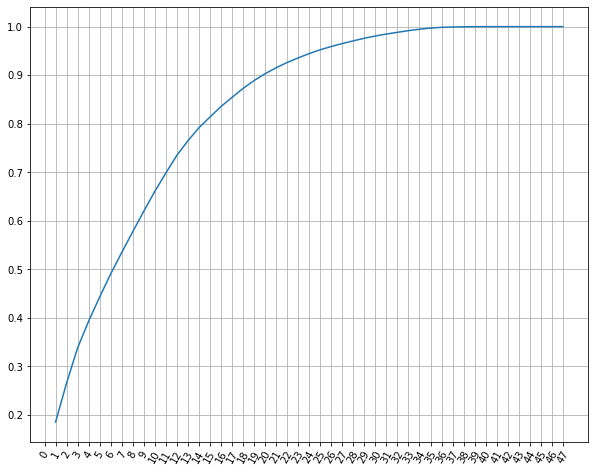

In [212]:
# explained variance
n = 47
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 2))
pipe_svc.fit(X,y)
plt.figure(figsize=(10,8))
plt.plot(range(1,n+1),pipe_svc.named_steps['pca'].explained_variance_ratio_.cumsum())
plt.xticks(list(range(0,48)),rotation = 60)
plt.grid()
plt.show()

# explained variance suggests the peak is attained at 34 ~ 100% variance explained

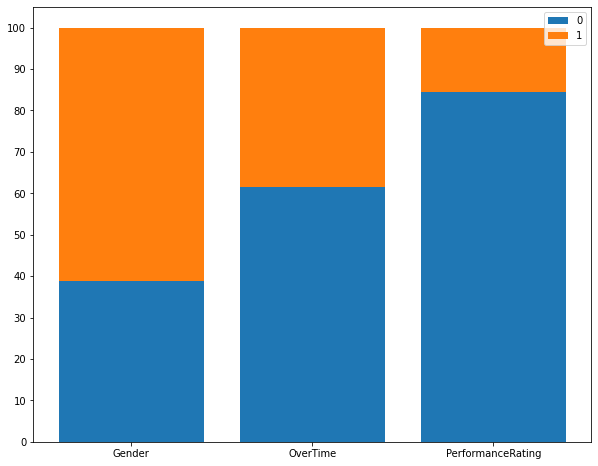

In [35]:
# binary columns

binary_cols = [f for f in X.columns if X[f].nunique()==2]

def plot_binary_cols(cols,X):
    plt.figure(figsize=(10,8))
    d0 = []
    d1 = []
    for i in cols:
        n = len(X)
        d0.append((X[i].value_counts()[0])*100/n)
        d1.append((X[i].value_counts()[1])*100/n)

    p1 = plt.bar(binary_cols,d0)
    p2 = plt.bar(binary_cols,d1,bottom = d0)
    plt.legend((p1[0],p2[0]),('0','1'),loc = 'best')
    plt.yticks(list(range(0,101,10)))
    plt.show()
    
plot_binary_cols(binary_cols,X)

In [10]:
# dropping performance rating - about only 15% values are 1. Might lead to overfitting
# score - 86.87*

categorical = [f for f in training.columns if training[f].dtype == object]
numeric = [f for f in X.columns if f not in categorical+['Id','Attrition','Behaviour','PerformanceRating']]

pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))


pipe_svc = make_pipeline(pre_pipe,SVC(probability=True,C = 1.5,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='accuracy')))

SVC:  0.9330682420661971


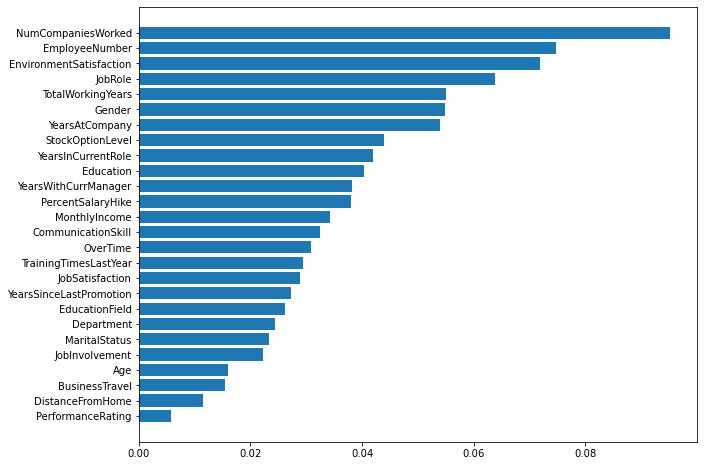

In [249]:
# feature importance - RF
pre_pipe = make_column_transformer((TargetEncoder(),categorical),(StandardScaler(),numeric),remainder = 'passthrough')
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())

pipe_rf.fit(X,y)
imp_features = X.iloc[:,pipe_rf.named_steps['randomforestclassifier'].feature_importances_.argsort()].columns

plt.figure(figsize=(10,8))
plt.barh(imp_features, sorted(pipe_rf.named_steps['randomforestclassifier'].feature_importances_))
plt.show()

NumCompaniesWorked
EmployeeNumber
EnvironmentSatisfaction
JobRole

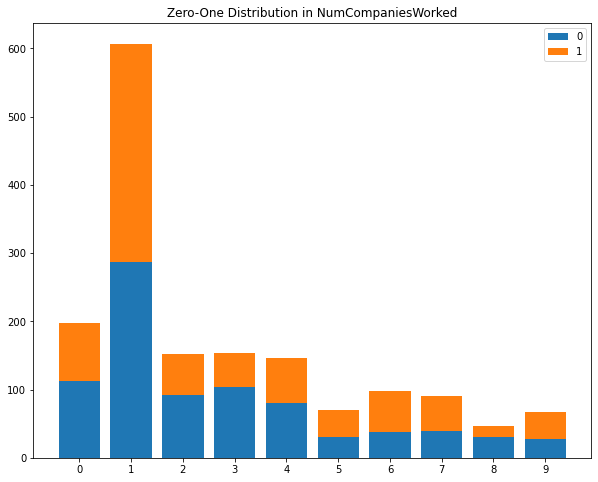

In [55]:
# distribution of num companies worked
plt.figure(figsize=(10,8))

num_companies = np.unique(train_data['NumCompaniesWorked'])
num_com_atr = pd.DataFrame(train_data.groupby(['NumCompaniesWorked','Attrition'])['NumCompaniesWorked'].count().rename('count')).reset_index()

atr0 = (num_com_atr['count'][num_com_atr['Attrition']==0])
atr1 = (num_com_atr['count'][num_com_atr['Attrition']==1])

p1 = plt.bar(num_companies,atr0)
p2 = plt.bar(num_companies,atr1,bottom=atr0)

plt.title('Zero-One Distribution in NumCompaniesWorked')
plt.xticks(list(range(0,10)))
plt.legend((p1[0],p2[0]),('0','1'))
plt.show()

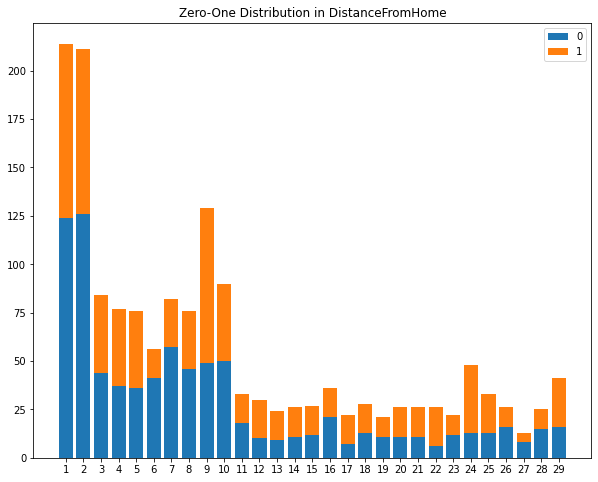

In [57]:
# distribution of distance from home
plt.figure(figsize=(10,8))

dist = np.unique(train_data['DistanceFromHome'])
num_com_atr = pd.DataFrame(train_data.groupby(['DistanceFromHome','Attrition'])['DistanceFromHome'].count().rename('count')).reset_index()

atr0 = num_com_atr['count'][num_com_atr['Attrition']==0]
atr1 = num_com_atr['count'][num_com_atr['Attrition']==1]

p1 = plt.bar(dist,atr0)
p2 = plt.bar(dist,atr1,bottom=atr0)

plt.title('Zero-One Distribution in DistanceFromHome')
plt.xticks(list(range(1,len(dist)+1)))
plt.legend((p1[0],p2[0]),('0','1'))
plt.show()

In [65]:
# new feature mean_d 
mean_d = round(X['DistanceFromHome'].mean())
# feature generation

X_new = X.copy()
X_new['mean_d'] = X['DistanceFromHome'].apply(lambda x: 0 if x<= mean_d else 1)
test_data['mean_d'] = test_data['DistanceFromHome'].apply(lambda x: 0 if x<= mean_d else 1)

categorical = [f for f in training.columns if training[f].dtype == object] + ['mean_d']
numeric = [f for f in X_new.columns if f not in categorical+['Id','Attrition','Behaviour','PerformanceRating']]

pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))


pipe_svc = make_pipeline(pre_pipe,SVC(probability=True,C = 1.5,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X_new,y=y,cv=skf,estimator=pipe_svc,scoring='accuracy')))

SVC:  0.9379800045444217


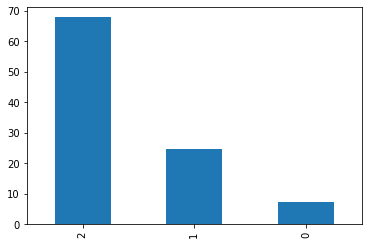

In [77]:
# business travel distribution
((X['BusinessTravel'].value_counts())*100/len(X)).plot(kind = 'bar')
plt.show()

# almost 70% values in 2 and 30% in 1 and 0

In [89]:
# dropping Business Travel + Distance From Home
categorical = [f for f in training.columns if training[f].dtype == object] 
numeric = [f for f in X.columns if f not in categorical+['Id','Attrition','Behaviour','PerformanceRating','BusinessTravel','DistanceFromHome']]

pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric),remainder = 'drop')


pipe_svc = make_pipeline(pre_pipe,SVC(probability=True,C = 1.5,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='accuracy')))

SVC:  0.9336703779444067


In [103]:
# error analysis
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.3,stratify = y, shuffle = True, random_state = 42)

categorical = [f for f in training.columns if training[f].dtype == object]
numeric = [f for f in X.columns if f not in categorical+['Id','Attrition','Behaviour','PerformanceRating']]

pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))
pipe_svc = make_pipeline(pre_pipe,SVC(probability=True,C = 1.5,kernel='rbf',random_state=42))
pipe_svc.fit(X_train,y_train)
prediction = pipe_svc.predict(X_val)
print('Val Acc: ',pipe_svc.score(X_val,y_val))


error_df = pd.DataFrame(np.array([prediction,y_val]).T,columns=['pred','true'])
error_df = error_df[error_df['pred']!=error_df['true']]
print('Mis-classified: ', error_df.shape[0])
error_df['pred'].value_counts()

Val Acc:  0.918200408997955
Mis-classified:  40


1    36
0     4
Name: pred, dtype: int64

In [36]:
# pca + dropped performance rating + dropped Business Travel + New feature BT - 0.85

X_new = X.copy()
test_new = test_data.copy()



X_new['BT'] = X_new['BusinessTravel'].apply(lambda x: 1 if x == 2 else 0)
test_new['BT'] = test_new['BusinessTravel'].apply(lambda x: 1 if x == 2 else 0)

categorical = [f for f in training.columns if training[f].dtype == object]
numeric = [f for f in X_new.columns if f not in categorical+['Id','Attrition','Behaviour','PerformanceRating','BusinessTravel']]

pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))


pipe_svc = make_pipeline(pre_pipe,PCA(n_components = 34),SVC(probability=True,C = 1.5,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X_new,y=y,cv=skf,estimator=pipe_svc,scoring='accuracy')))

SVC:  0.9471938195864575


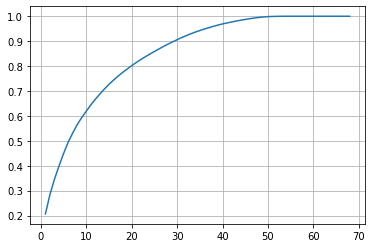

In [90]:
n = 68
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1.5,kernel='rbf'))
pipe_svc.fit(X,y)
plt.plot(range(1,n+1),pipe_svc.named_steps['pca'].explained_variance_ratio_.cumsum())
plt.grid()
plt.show()

In [97]:
# dropping performance rating - about only 15% values are 1. Might lead to overfitting + PCA - 86.891%*

categorical = [f for f in X.columns if training[f].dtype == object]
numeric = [f for f in X.columns if f not in categorical+['Id','Attrition','Behaviour','PerformanceRating']]

pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))


pipe_svc = make_pipeline(pre_pipe,PCA(n_components=34),SVC(probability=True,C = 1.75,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='accuracy')))

SVC:  0.949644020298417


Dropping duplicates

In [355]:
train_unq = train_data.drop_duplicates()

In [356]:
train_unq.shape

(1000, 27)

In [357]:
X = train_unq.drop('Attrition',axis = 1)
y = train_unq['Attrition']

In [358]:
# Standard Scaling
skf = StratifiedKFold(n_splits = 10,random_state=42,shuffle=True)

categorical = [f for f in training.columns if training[f].dtype == object]
numeric = [f for f in X.columns if f not in categorical+['Id','Attrition','Behaviour','PerformanceRating']]

pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
pipe_xgb = make_pipeline(pre_pipe,XGBClassifier())
pipe_svc = make_pipeline(pre_pipe,SVC(probability=True))


print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='roc_auc')))
print('XGB: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_xgb,scoring='roc_auc')))
print('SVC:',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

RF:  0.8048612570028011
XGB:  0.7940574229691877
SVC: 0.822673319327731


In [262]:
n = 46
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

SVC:  0.8192405462184873


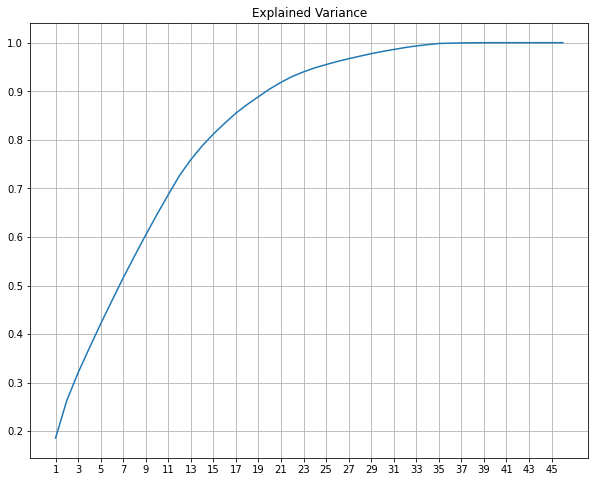

In [260]:
plt.figure(figsize=(10,8))
pipe_svc.fit(X,y)
plt.plot(range(1,n+1),pipe_svc.named_steps['pca'].explained_variance_ratio_.cumsum())
plt.xticks(range(1,n+1,2))
plt.title('Explained Variance')
plt.grid()
plt.show()
# 34 componenets explaining 100% variance

In [263]:
# 0.867 

n = 34
pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric),remainder = 'passthrough')
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

SVC:  0.8196367296918767


In [146]:
# checking the number of unique values in features
for f in X.columns:
    print(str(f),X[f].nunique())

Age 43
BusinessTravel 3
Department 3
DistanceFromHome 29
Education 5
EducationField 6
EmployeeNumber 1000
EnvironmentSatisfaction 4
Gender 2
JobInvolvement 4
JobRole 9
JobSatisfaction 4
MaritalStatus 3
MonthlyIncome 941
NumCompaniesWorked 10
OverTime 2
PercentSalaryHike 15
PerformanceRating 2
StockOptionLevel 4
TotalWorkingYears 39
TrainingTimesLastYear 7
YearsAtCompany 36
YearsInCurrentRole 19
YearsSinceLastPromotion 16
YearsWithCurrManager 18
CommunicationSkill 5


In [252]:
# target encoding SVC - increased - 0.80 ~ 0.84
pre_process_cols = [f for f in X.columns if f not in ['PerformanceRating']]

categorical_ohe = [f for f in pre_process_cols if training[f].dtype == object or training[f].nunique()<=5]
categorical_target = [f for f in pre_process_cols if training[f].nunique()<20 and f not in categorical_ohe]
numeric = [f for f in pre_process_cols if f not in categorical_ohe+categorical_target]

pre_pipe = make_column_transformer((OneHotEncoder(),categorical_ohe),(TargetEncoder(),categorical_target),(StandardScaler(),numeric))
pipe_svc = make_pipeline(pre_pipe,SVC(probability=True))
print('SVC:',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

SVC: 0.8401390056022408


In [180]:
# PCA with target encoding
n = 66

pre_pipe = make_column_transformer((OneHotEncoder(),categorical_ohe),(TargetEncoder(),categorical_target),(StandardScaler(),numeric))
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))


SVC:  0.8150561974789916


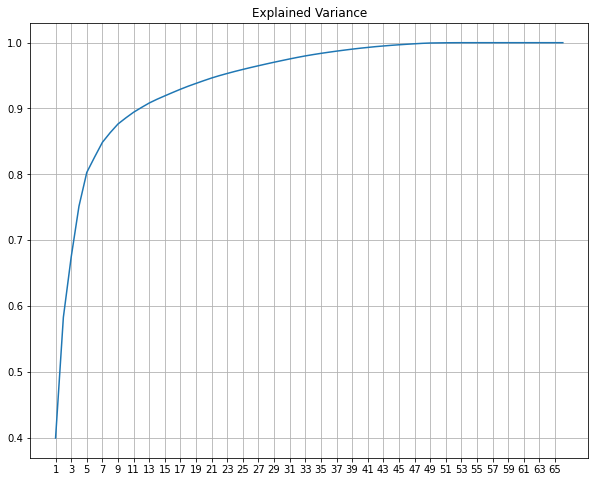

In [186]:
plt.figure(figsize=(10,8))
pipe_svc.fit(X,y)
plt.plot(range(1,n+1),pipe_svc.named_steps['pca'].explained_variance_ratio_.cumsum())
plt.xticks(range(1,n+1,2))
plt.title('Explained Variance')
plt.grid()
plt.show()

In [256]:
# score decreases
n = 50

pre_pipe = make_column_transformer((OneHotEncoder(),categorical_ohe),(TargetEncoder(),categorical_target),(StandardScaler(),numeric))
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True ,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

SVC:  0.8151889005602241


In [375]:
# tuning

n = 34
pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric),remainder = 'passthrough')
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf'))

param_grid = {
    
    'svc__C':[0.001,0.01,0.1,1,10,100,1000],
    'svc__gamma': ['auto','scale'],
    'svc__class_weight': ['balanced',None]
}

grid_search = GridSearchCV(pipe_svc,param_grid=param_grid,cv = skf, verbose=2, n_jobs = -1,scoring='roc_auc')
grid_search.fit(X,y)
print('Best score ',grid_search.best_score_)
print('Best parameters ',grid_search.best_params_)
best_svc = grid_search.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.7s


Best score  0.8048380602240897
Best parameters  {'svc__C': 0.1, 'svc__class_weight': None, 'svc__gamma': 'auto'}


[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   10.3s finished


In [376]:
# fine tuning - 0.88319*
pipe_svc = make_pipeline(pre_pipe,SVC(probability=True,class_weight=None,gamma='auto'))
param_grid={
    'svc__C':[0.01,0.03,0.05,0.07,0.1,0.3,0.5,0.7,1]  
}
grid_search = GridSearchCV(pipe_svc,param_grid=param_grid,cv = skf, verbose=2, n_jobs = -1,scoring = 'roc_auc')
grid_search.fit(X,y)
print('Best score ',grid_search.best_score_)
print('Best parameters ',grid_search.best_params_)
best_svc = grid_search.best_estimator_

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s


Best score  0.8090831582633052
Best parameters  {'svc__C': 0.05}


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.6s finished


In [250]:
# random forest - target encoding ~ increased

pre_process_cols = [f for f in X.columns if f not in ['PerformanceRating']]

categorical_ohe = [f for f in pre_process_cols if training[f].dtype == object or training[f].nunique()<=5]
categorical_target = [f for f in pre_process_cols if training[f].nunique()<30 and f not in categorical_ohe]
numeric = [f for f in pre_process_cols if f not in categorical_ohe+categorical_target]

pre_pipe = make_column_transformer((OneHotEncoder(),categorical_ohe),(TargetEncoder(),categorical_target),(StandardScaler(),numeric))
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier(n_jobs=-1))
print('RF:',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

RF: 0.8401390056022408


In [287]:
# random forest
pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric),remainder = 'passthrough')
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier(n_jobs=-1))
print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='roc_auc')))

RF:  0.7970494572829132


In [334]:
plt.figure(figsize=(10,8))
np.abs(train_data.corr()['Attrition']).sort_values()

PerformanceRating          0.010202
PercentSalaryHike          0.012668
Gender                     0.024573
BusinessTravel             0.029573
NumCompaniesWorked         0.034763
Education                  0.041390
EducationField             0.046867
YearsSinceLastPromotion    0.050379
EmployeeNumber             0.051512
Department                 0.099875
CommunicationSkill         0.103379
TrainingTimesLastYear      0.105663
DistanceFromHome           0.109224
EnvironmentSatisfaction    0.111746
JobRole                    0.125322
JobSatisfaction            0.148012
JobInvolvement             0.159710
StockOptionLevel           0.175496
MaritalStatus              0.198327
Age                        0.200596
YearsWithCurrManager       0.222752
YearsAtCompany             0.230061
MonthlyIncome              0.240479
TotalWorkingYears          0.262922
YearsInCurrentRole         0.269408
OverTime                   0.321194
Attrition                  1.000000
Name: Attrition, dtype: floa

<Figure size 720x576 with 0 Axes>

In [362]:
# dropping columns based on above heatmap
drop_colums = ['BusinessTravel','PerformanceRating','PercentSalaryHike','Gender']
X_new = X.copy()

categorical = [f for f in X.columns if training[f].dtype == object if f not in drop_colums]
numeric = [f for f in X_new.columns if f not in categorical+['Id','Attrition','Behaviour']+drop_colums] 

X_new = X_new.drop(drop_colums,axis = 1)

pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric),remainder = 'passthrough')
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier(n_jobs=-1))
pipe_xgb = make_pipeline(pre_pipe,XGBClassifier(n_jobs=-1))
print('RF: ',np.mean(cross_val_score(X=X_new,y=y,cv=skf,estimator=pipe_rf,scoring='roc_auc')))
print('XGB: ',np.mean(cross_val_score(X=X_new,y=y,cv=skf,estimator=pipe_xgb,scoring='roc_auc')))

RF:  0.7961744572829131
XGB:  0.8036299019607844


In [363]:
# tuning RF
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
params_grid = {
    'randomforestclassifier__n_estimators':Integer(100,1200),
    'randomforestclassifier__max_depth':Integer(5,50),
    'randomforestclassifier__min_samples_split':Integer(2,100),
    'randomforestclassifier__min_samples_leaf':Integer(1,20),
    'randomforestclassifier__max_features':Categorical(['log2','sqrt',None])
}


bae_search = BayesSearchCV(estimator=pipe_rf,n_jobs=-1,search_spaces=params_grid,cv = skf,verbose=2,scoring = 'roc_auc',n_iter=100,random_state=42)
bae_search.fit(X,y)
print(bae_search.best_score_)
print(bae_search.best_params_)
best_rf = bae_search.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.1s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.2s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.4s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.3s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.4s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.4s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.3s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.4s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
C:\Users\Arpan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


0.8175878851540618
OrderedDict([('randomforestclassifier__max_depth', 50), ('randomforestclassifier__max_features', 'log2'), ('randomforestclassifier__min_samples_leaf', 9), ('randomforestclassifier__min_samples_split', 2), ('randomforestclassifier__n_estimators', 1200)])


In [383]:
# new feature
X_new = X.copy()
X_new['avgyrsincomp'] = X_new['TotalWorkingYears']/X_new['NumCompaniesWorked']
X_new['avgyrsincomp'] = X_new['avgyrsincomp'].apply(lambda x: x if x!= np.inf else 0)
X_new['avgyrs'] = (X_new['YearsInCurrentRole'] + X_new['YearsSinceLastPromotion'] + X['YearsWithCurrManager'])/3
numeric_ = numeric + ['avgyrsincomp'] + ['avgyrs']
pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric_),remainder = 'passthrough')
print('SVC: ',np.mean(cross_val_score(X=X_new,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

SVC:  0.7913970588235294


In [378]:
X.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill
0,30,0,1,2,3,3,571,3,0,3,2,4,2,2564,0,0,14,0,0,12,2,11,7,6,7,4
1,36,2,1,12,4,1,1614,3,0,3,4,3,1,4663,9,1,12,0,2,7,2,3,2,1,1,2
2,55,2,2,2,1,3,842,3,1,3,7,4,2,5160,4,0,16,0,0,12,3,9,7,7,3,5
3,39,2,1,24,1,1,2014,1,1,3,6,4,2,4108,7,0,13,0,0,18,2,7,7,1,7,4
4,37,2,1,3,3,4,689,3,1,3,4,3,1,9434,1,0,15,0,1,10,2,10,7,7,8,1


Submission

In [364]:
test = pd.read_csv('test.csv')
X_s = train_data.drop('Attrition',axis=1)
y_s = train_data['Attrition']
best_rf.fit(X,y)
prediction = best_rf.predict_proba(test_data)[:,1]
submission = pd.DataFrame(prediction,columns=['Attrition'])
submission['Id'] = test['Id']
submission = submission[['Id','Attrition']]
submission.to_csv('submissionfile42.csv',index = None)